In [104]:

# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree

# Para realizar la regresión lineal y la evaluación del modelo
# -----------------------------------------------------------------------
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


from sklearn.model_selection import KFold,LeaveOneOut, cross_val_score


from sklearn.preprocessing import StandardScaler

from tqdm import tqdm

import sys
sys.path.append("../../")
from src.soporte_metricas import (
    obtener_metricas,
    comparar_arboles,
    residual_plot,
    generar_df_comparador
)
pd.options.display.float_format = "{:,.2f}".format
# Ignorar los warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("../../datos/06_Modelo6/06_autorenew_target_encoded.csv",index_col=0)
df.sample()

,offerType,vehicleType,fuelType,gearbox,notRepairedDamage,kilometer,price,yearOfRegistration,gama,powerCV_robust_scaler
248477,"6,145.40","6,813.85","8,645.84","4,956.84","7,025.45","4,052.00","17,500.00","12,436.82","7,471.21","7,818.48"


# Decision Tree
- El árbol de decisiones se usa para modelos no lineales
- Vamos a probarlo a ver si mejora nuestras métricas

In [3]:
X = df.drop(columns="price")
y = df[["price"]]
X_train, X_test, y_train, y_test = train_test_split(X, # Todo menos la Variable Respuesta
                                                    y, # La variable Respuesta
                                                    train_size=0.7, # Como dividir los datos en este caso 80% train, 20% test
                                                    random_state=42, # Semilla, para que lo haga igual para cualquier persona
                                                    shuffle=True 
                                                    )

In [4]:
modelo_arbol = DecisionTreeRegressor()
modelo_arbol.fit(X_train,y_train)
y_pred_test = modelo_arbol.predict(X_test)
y_pred_train = modelo_arbol.predict(X_train)
df_metricas = obtener_metricas(y_train,y_pred_train,y_test,y_pred_test)
df_metricas

,r2_score,MAE,MSE,RMSE
train,0.93,"1,052.11","4,097,608.57","2,024.26"
test,0.76,"1,739.64","12,736,704.10","3,568.85"


# Mejora sustancial! pero...
- Seguimos teniendo un error bastante alto.
- Y aquí tenemos un overfitting de manual
- Vamos a paralizar este mo

Con todos estos params podemos intentar conseguir algo mucho mejor

In [5]:
# Parámetros a evaluar
params_arbol = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [20, 30, 40, 50],
    'min_samples_leaf': [5, 10, 15, 20],
    'max_leaf_nodes': [10 , 20, 30, 40]
}

grid_search_arbol = GridSearchCV(DecisionTreeRegressor(),
                                 param_grid= params_arbol,
                                 cv = 5, # Cross Validation de 5 grupos solo
                                 scoring="neg_mean_squared_error",
                                 n_jobs=-1)

grid_search_arbol.fit(X_train, y_train)
modelo_final_arbol = grid_search_arbol.best_estimator_

In [6]:
modelo_final_arbol.fit(X_train,y_train)
y_pred_test = modelo_final_arbol.predict(X_test)
y_pred_train = modelo_final_arbol.predict(X_train)
df_metricas = obtener_metricas(y_train,y_pred_train,y_test,y_pred_test)
df_metricas

,r2_score,MAE,MSE,RMSE
train,0.67,"2,511.17","18,535,599.23","4,305.30"
test,0.66,"2,499.02","18,031,414.75","4,246.34"


In [7]:
# modelo_final_arbol

Ha tardado 49 Segundos

# Que nos dice
La primera iteración dice que el mejor resultado es el siguiente:
- max_depth = 10
- max_leaf_nodes = 40
- min_samples_leaf = 5
- min_samples_split = 20

Esto no significa que sea el mejor aún nos dice que:
- max_depth = Entre 5 y 10 y 15
- max_leaf_nodes = Entre 35 y 40 y 45
- min_samples_leaf = Entre 0 y 7
- min_samples_split = Entre 15 y 20 y 25

Así que toca nueva iteración probando entre esos rangos

In [18]:
# Parámetros a evaluar
params_arbol = {
    'max_depth': [7, 8, 9, 10],
    'max_leaf_nodes': [38,39,40,41],
    'min_samples_leaf': [3,4,5,6,7,8],
    'min_samples_split': [16,17,18,19,20,21,22,23]   
}

grid_search_arbol = GridSearchCV(DecisionTreeRegressor(),
                                 param_grid= params_arbol,
                                 cv = 5, # Cross Validation de 5 grupos solo
                                 scoring="neg_mean_squared_error",
                                 verbose=2,
                                 n_jobs=-1)

grid_search_arbol.fit(X_train, y_train)
modelo_final_arbol2 = grid_search_arbol.best_estimator_


Fitting 5 folds for each of 768 candidates, totalling 3840 fits


In [19]:
modelo_final_arbol2.fit(X_train,y_train)
y_pred_test = modelo_final_arbol2.predict(X_test)
y_pred_train = modelo_final_arbol2.predict(X_train)
df_metricas2 = obtener_metricas(y_train,y_pred_train,y_test,y_pred_test)
df_metricas2

,r2_score,MAE,MSE,RMSE
train,0.67,"2,504.21","18,444,103.30","4,294.66"
test,0.66,"2,494.09","17,969,163.54","4,239.01"


In [20]:
modelo_final_arbol2

DecisionTreeRegressor(max_depth=8, max_leaf_nodes=41, min_samples_leaf=3,
                      min_samples_split=16)

# Resultados
- max_depth = 8
- max_leaf_nodes = 41
- min_samples_leaf = 3
- min_samples_split = 16
### Otra iteración para ver si podemos ver el numero de nodes


In [21]:
# Parámetros a evaluar
params_arbol = {
    'max_depth': [7, 8, 9],
    'max_leaf_nodes': [40,41,42,43,44],
    'min_samples_leaf': [1,2,3,4],
    'min_samples_split': [13, 14, 15, 16, 17]   
}

grid_search_arbol = GridSearchCV(DecisionTreeRegressor(),
                                 param_grid= params_arbol,
                                 cv = 5, # Cross Validation de 5 grupos solo
                                 scoring="neg_mean_squared_error",
                                 verbose=2,
                                 n_jobs=-1)

grid_search_arbol.fit(X_train, y_train)
modelo_final_arbol3 = grid_search_arbol.best_estimator_


Fitting 5 folds for each of 300 candidates, totalling 1500 fits


C:\Users\ruipe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [22]:
modelo_final_arbol3.fit(X_train,y_train)
y_pred_test = modelo_final_arbol3.predict(X_test)
y_pred_train = modelo_final_arbol3.predict(X_train)
df_metricasv3 = obtener_metricas(y_train,y_pred_train,y_test,y_pred_test)
df_metricasv3

,r2_score,MAE,MSE,RMSE
train,0.67,"2,460.38","18,199,421.63","4,266.08"
test,0.67,"2,452.47","17,756,301.39","4,213.82"


In [23]:
modelo_final_arbol3

DecisionTreeRegressor(max_depth=8, max_leaf_nodes=44, min_samples_split=13)

# Resultados
- max_depth = 8
- max_leaf_nodes = 44
- min_samples_leaf = Default
- min_samples_split = 13

### Nueva iteración
- Quiero comprobar max_depth y max_leaf_nodes

In [24]:
# Parámetros a evaluar
params_arbol = {
    'max_depth': [7, 8, 9],
    'max_leaf_nodes': [43,44,45,50],
    'min_samples_leaf': [2],
    'min_samples_split': [5,8,10,11,12,13]   
}

grid_search_arbol = GridSearchCV(DecisionTreeRegressor(),
                                 param_grid= params_arbol,
                                 cv = 5, # Cross Validation de 5 grupos solo
                                 scoring="neg_mean_squared_error",
                                 verbose=2,
                                 n_jobs=-1)

grid_search_arbol.fit(X_train, y_train)
modelo_final_arbol4 = grid_search_arbol.best_estimator_


Fitting 5 folds for each of 72 candidates, totalling 360 fits


C:\Users\ruipe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [25]:
modelo_final_arbol4.fit(X_train,y_train)
y_pred_test = modelo_final_arbol4.predict(X_test)
y_pred_train = modelo_final_arbol4.predict(X_train)
df_metricas4 = obtener_metricas(y_train,y_pred_train,y_test,y_pred_test)
df_metricas4

,r2_score,MAE,MSE,RMSE
train,0.68,"2,418.98","17,754,300.64","4,213.59"
test,0.68,"2,410.67","17,307,872.38","4,160.27"


In [26]:
modelo_final_arbol4

DecisionTreeRegressor(max_depth=9, max_leaf_nodes=50, min_samples_leaf=2,
                      min_samples_split=5)

# Resultados
- max_depth = 9
- max_leaf_nodes = 50
- min_samples_leaf = Default
- min_samples_split = 5

### Nueva iteración
- Quiero comprobar max_depth y max_leaf_nodes

In [28]:
# Parámetros a evaluar
params_arbol = {
    'max_depth': [8, 9,10,11,12],
    'max_leaf_nodes': [45,50,60,70],
    'min_samples_leaf': [1,2,3],
    'min_samples_split': [1,2,3,4,5,8,10]   
}

grid_search_arbol = GridSearchCV(DecisionTreeRegressor(),
                                 param_grid= params_arbol,
                                 cv = 5, # Cross Validation de 5 grupos solo
                                 scoring="neg_mean_squared_error",
                                 verbose=2,
                                 n_jobs=-1)

grid_search_arbol.fit(X_train, y_train)
modelo_final_arbol5 = grid_search_arbol.best_estimator_


Fitting 5 folds for each of 420 candidates, totalling 2100 fits


C:\Users\ruipe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
300 fits failed out of a total of 2100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ruipe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ruipe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-

In [29]:
modelo_final_arbol5.fit(X_train,y_train)
y_pred_test = modelo_final_arbol5.predict(X_test)
y_pred_train = modelo_final_arbol5.predict(X_train)
df_metricas5 = obtener_metricas(y_train,y_pred_train,y_test,y_pred_test)
df_metricas5

,r2_score,MAE,MSE,RMSE
train,0.70,"2,338.03","16,672,370.12","4,083.18"
test,0.69,"2,331.48","16,351,103.82","4,043.65"


In [30]:
modelo_final_arbol5

DecisionTreeRegressor(max_depth=10, max_leaf_nodes=70)

# Resultados
- max_depth = 10
- max_leaf_nodes = 70
- min_samples_leaf = Default
- min_samples_split = Default

### Nueva iteración
- Quiero comprobar max_depth y max_leaf_nodes

In [31]:
# Parámetros a evaluar
params_arbol = {
    'max_depth': [9,10,11,12],
    'max_leaf_nodes': [60,70,80,90,100,200],
    'min_samples_leaf': [1,2,3],
    'min_samples_split': [1,2,3,4]   
}

grid_search_arbol = GridSearchCV(DecisionTreeRegressor(),
                                 param_grid= params_arbol,
                                 cv = 5, # Cross Validation de 5 grupos solo
                                 scoring="neg_mean_squared_error",
                                 verbose=2,
                                 n_jobs=-1)

grid_search_arbol.fit(X_train, y_train)
modelo_final_arbol6 = grid_search_arbol.best_estimator_


Fitting 5 folds for each of 288 candidates, totalling 1440 fits


C:\Users\ruipe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
360 fits failed out of a total of 1440.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
360 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ruipe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ruipe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-

In [32]:
modelo_final_arbol6.fit(X_train,y_train)
y_pred_test = modelo_final_arbol6.predict(X_test)
y_pred_train = modelo_final_arbol6.predict(X_train)
df_metricas6 = obtener_metricas(y_train,y_pred_train,y_test,y_pred_test)
df_metricas6

,r2_score,MAE,MSE,RMSE
train,0.75,"2,112.18","13,764,440.90","3,710.05"
test,0.74,"2,121.52","14,041,773.26","3,747.24"


In [33]:
modelo_final_arbol6

DecisionTreeRegressor(max_depth=12, max_leaf_nodes=200, min_samples_leaf=3)

# Resultados
- max_depth = 12
- max_leaf_nodes = 200
- min_samples_leaf = 3
- min_samples_split = Default

### Nueva iteración
- Quiero comprobar max_depth y max_leaf_nodes

In [34]:
# Parámetros a evaluar
params_arbol = {
    'max_depth': [10,11,12,13,14],
    'max_leaf_nodes': [100,200,300,400,500,1000],
    'min_samples_leaf': [1,2,3,4,5,6,7],
    'min_samples_split': [1,2,3,4]   
}

grid_search_arbol = GridSearchCV(DecisionTreeRegressor(),
                                 param_grid= params_arbol,
                                 cv = 5, # Cross Validation de 5 grupos solo
                                 scoring="neg_mean_squared_error",
                                 verbose=2,
                                 n_jobs=-1)

grid_search_arbol.fit(X_train, y_train)
modelo_final_arbol7 = grid_search_arbol.best_estimator_


Fitting 5 folds for each of 840 candidates, totalling 4200 fits


C:\Users\ruipe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
1050 fits failed out of a total of 4200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1050 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ruipe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ruipe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loca

In [35]:
modelo_final_arbol7.fit(X_train,y_train)
y_pred_test = modelo_final_arbol7.predict(X_test)
y_pred_train = modelo_final_arbol7.predict(X_train)
df_metricas7 = obtener_metricas(y_train,y_pred_train,y_test,y_pred_test)
df_metricas7

,r2_score,MAE,MSE,RMSE
train,0.81,"1,844.20","10,577,958.69","3,252.38"
test,0.78,"1,897.16","11,796,500.44","3,434.60"


In [36]:
modelo_final_arbol7

DecisionTreeRegressor(max_depth=14, max_leaf_nodes=1000, min_samples_leaf=7)

# Resultados
- max_depth = 14
- max_leaf_nodes = 1000
- min_samples_leaf = 7
- min_samples_split = 21

### Nueva iteración
- Quiero comprobar max_depth y max_leaf_nodes

In [37]:
# Parámetros a evaluar
params_arbol = {
    'max_depth': [13,14,15,16,20],
    'max_leaf_nodes': [1000,2000,3000],
    'min_samples_leaf': [7,8,9],
    'min_samples_split': [1,2,3,4]   
}

grid_search_arbol = GridSearchCV(DecisionTreeRegressor(),
                                 param_grid= params_arbol,
                                 cv = 5, # Cross Validation de 5 grupos solo
                                 scoring="neg_mean_squared_error",
                                 verbose=2,
                                 n_jobs=-1)

grid_search_arbol.fit(X_train, y_train)
modelo_final_arbol8 = grid_search_arbol.best_estimator_


Fitting 5 folds for each of 180 candidates, totalling 900 fits


C:\Users\ruipe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
225 fits failed out of a total of 900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
225 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ruipe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ruipe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-p

In [38]:
modelo_final_arbol8.fit(X_train,y_train)
y_pred_test = modelo_final_arbol8.predict(X_test)
y_pred_train = modelo_final_arbol8.predict(X_train)
df_metricas8 = obtener_metricas(y_train,y_pred_train,y_test,y_pred_test)
df_metricas8

,r2_score,MAE,MSE,RMSE
train,0.83,"1,684.34","9,358,128.25","3,059.11"
test,0.80,"1,778.68","10,875,299.05","3,297.77"


In [39]:
modelo_final_arbol8

DecisionTreeRegressor(max_depth=20, max_leaf_nodes=3000, min_samples_leaf=9,
                      min_samples_split=3)

# Resultados
- max_depth = 20
- max_leaf_nodes = 3000
- min_samples_leaf = 9
- min_samples_split = 3

### Nueva iteración
- Quiero comprobar max_depth y max_leaf_nodes

In [46]:
# Parámetros a evaluar
params_arbol = {
    'max_depth': [13,14,15,16,20],
    'max_leaf_nodes': [3000,4000,5000],
    'min_samples_leaf': [8,9,10,11,12],
    'min_samples_split': [2,3,4,5,10]   
}

grid_search_arbol = GridSearchCV(DecisionTreeRegressor(),
                                 param_grid= params_arbol,
                                 cv = 5, # Cross Validation de 5 grupos solo
                                 scoring="neg_mean_squared_error",
                                 verbose=2,
                                 n_jobs=-1)

grid_search_arbol.fit(X_train, y_train)
modelo_final_arbol9 = grid_search_arbol.best_estimator_


Fitting 5 folds for each of 375 candidates, totalling 1875 fits


In [47]:
modelo_final_arbol9.fit(X_train,y_train)
y_pred_test = modelo_final_arbol9.predict(X_test)
y_pred_train = modelo_final_arbol9.predict(X_train)
df_metricas9 = obtener_metricas(y_train,y_pred_train,y_test,y_pred_test)
df_metricas9

,r2_score,MAE,MSE,RMSE
train,0.84,"1,630.60","9,118,248.12","3,019.64"
test,0.80,"1,747.19","10,791,764.06","3,285.08"


In [48]:
modelo_final_arbol9

DecisionTreeRegressor(max_depth=20, max_leaf_nodes=5000, min_samples_leaf=9,
                      min_samples_split=10)

# Resultados
- max_depth = 20
- max_leaf_nodes = 5000
- min_samples_leaf = 9
- min_samples_split = 10

### Nueva iteración
- Quiero comprobar max_depth y max_leaf_nodes

In [49]:
# Parámetros a evaluar
params_arbol = {
    'max_depth': [20,25,30,40,50],
    'max_leaf_nodes': [5000,8000,10000],
    'min_samples_leaf': [8,9,10,11],
    'min_samples_split': [8,9,10,15,20]
}

grid_search_arbol = GridSearchCV(DecisionTreeRegressor(),
                                 param_grid= params_arbol,
                                 cv = 5, # Cross Validation de 5 grupos solo
                                 scoring="neg_mean_squared_error",
                                 verbose=2,
                                 n_jobs=-1)

grid_search_arbol.fit(X_train, y_train)
modelo_final_arbol10 = grid_search_arbol.best_estimator_


Fitting 5 folds for each of 300 candidates, totalling 1500 fits


In [50]:
modelo_final_arbol10.fit(X_train,y_train)
y_pred_test = modelo_final_arbol10.predict(X_test)
y_pred_train = modelo_final_arbol10.predict(X_train)
df_metricas10 = obtener_metricas(y_train,y_pred_train,y_test,y_pred_test)
df_metricas10

,r2_score,MAE,MSE,RMSE
train,0.84,"1,585.84","8,892,653.92","2,982.06"
test,0.80,"1,724.18","10,645,920.99","3,262.81"


In [51]:
modelo_final_arbol10

DecisionTreeRegressor(max_depth=50, max_leaf_nodes=10000, min_samples_leaf=8,
                      min_samples_split=20)

# Resultados
- max_depth = 50
- max_leaf_nodes = 10000
- min_samples_leaf = 8
- min_samples_split = 20

### Nueva iteración
- Quiero comprobar max_depth y max_leaf_nodes

In [83]:
# Parámetros a evaluar
params_arbol = {
    'max_depth': [41,42,43,44,45],
    'max_leaf_nodes': [9129,9130,9131,9132],
    'min_samples_leaf': [6,7,8],
    'min_samples_split': [27,28,29,30]   
}

grid_search_arbol = GridSearchCV(DecisionTreeRegressor(),
                                 param_grid= params_arbol,
                                 cv = 5, # Cross Validation de 5 grupos solo
                                 scoring="neg_mean_squared_error",
                                 verbose=2,
                                 n_jobs=-1)

grid_search_arbol.fit(X_train, y_train)
modelo_final_arbol11 = grid_search_arbol.best_estimator_


Fitting 5 folds for each of 240 candidates, totalling 1200 fits


In [84]:
modelo_final_arbol11.fit(X_train,y_train)
y_pred_test = modelo_final_arbol11.predict(X_test)
y_pred_train = modelo_final_arbol11.predict(X_train)
df_metricas11 = obtener_metricas(y_train,y_pred_train,y_test,y_pred_test)
df_metricas11

,r2_score,MAE,MSE,RMSE
train,0.84,"1,595.02","9,040,014.85","3,006.66"
test,0.80,"1,729.79","10,705,155.04","3,271.87"


In [85]:
modelo_final_arbol11

DecisionTreeRegressor(max_depth=43, max_leaf_nodes=9130, min_samples_leaf=7,
                      min_samples_split=29)

# Mejores Resultados Posibles
- max_depth = 43
- max_leaf_nodes = 9130
- min_samples_leaf = 7
- min_samples_split = 29



In [93]:
# Parámetros a evaluar
params_arbol = {
    'max_depth': [43],
    'max_leaf_nodes': [9130],
    'min_samples_leaf': [7],
    'min_samples_split': [29]   
}

grid_search_arbol = GridSearchCV(DecisionTreeRegressor(),
                                 param_grid= params_arbol,
                                 cv = 5, # Cross Validation de 5 grupos solo
                                 scoring="neg_mean_squared_error",
                                 verbose=2,
                                 n_jobs=-1)

grid_search_arbol.fit(X_train, y_train)
modelo_final_arbol = grid_search_arbol.best_estimator_


Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [94]:
modelo_final_arbol.fit(X_train,y_train)
y_pred_test = modelo_final_arbol.predict(X_test)
y_pred_train = modelo_final_arbol.predict(X_train)
df_metricas = obtener_metricas(y_train,y_pred_train,y_test,y_pred_test)
df_metricas

,r2_score,MAE,MSE,RMSE
train,0.84,"1,595.02","9,040,014.85","3,006.66"
test,0.80,"1,729.68","10,703,552.68","3,271.63"


In [95]:
modelo_final_arbol

DecisionTreeRegressor(max_depth=43, max_leaf_nodes=9130, min_samples_leaf=7,
                      min_samples_split=29)

# ¿Porque es el mejor?
- Menor diferencia entre train y test
- R2 alto

# Probemos el modelo final

In [96]:
modelo_final_arbol.fit(X_train,y_train)
y_pred_test = modelo_final_arbol.predict(X_test)
y_pred_train = modelo_final_arbol.predict(X_train)
df_metricasvfinal = obtener_metricas(y_train,y_pred_train,y_test,y_pred_test)
df_metricasvfinal

,r2_score,MAE,MSE,RMSE
train,0.84,"1,595.02","9,040,014.85","3,006.66"
test,0.80,"1,729.82","10,705,810.22","3,271.97"


In [98]:
importancia = pd.DataFrame(modelo_final_arbol.feature_importances_,columns=["Importancia"], index= X.columns).sort_values(by="Importancia",ascending=False)
importancia

,Importancia
powerCV_robust_scaler,0.47
yearOfRegistration,0.21
kilometer,0.14
gama,0.07
vehicleType,0.06
fuelType,0.02
gearbox,0.02
notRepairedDamage,0.01
offerType,0.00


Podríamos eliminar offerType

<Axes: ylabel='None'>

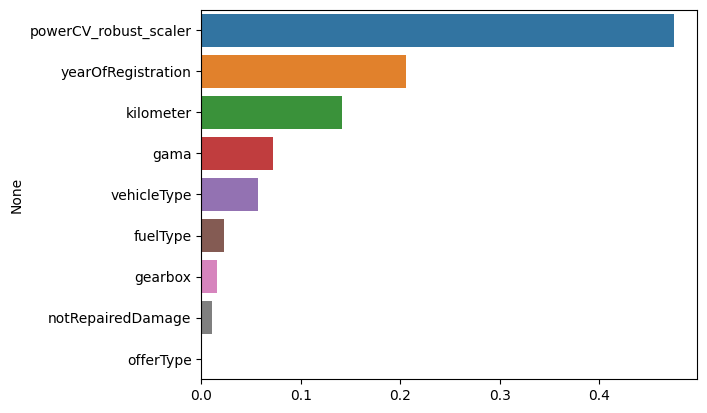

In [ ]:
sns.barplot(y=importancia.index,x=importancia["Importancia"].values,hue=importancia.index)

# Visualicemos el Residual Plot

In [105]:
df_comparador = generar_df_comparador(X_train,X_test,y_train,y_test,y_pred_train,y_pred_test,"price_pred")

In [107]:
df_comparador.head()

,offerType,vehicleType,fuelType,gearbox,notRepairedDamage,kilometer,yearOfRegistration,gama,powerCV_robust_scaler,price,price_pred
0,"6,145.40","10,590.91","8,645.84","4,956.84","2,759.00","6,475.13","12,436.82","7,471.21","15,581.44","18,300.00","19,843.33"
1,"6,145.40","13,192.13","8,645.84","10,535.78","3,756.20","6,475.13","5,379.46","7,471.21","7,818.48","9,800.00","10,036.40"
2,"6,145.40","3,146.71","5,153.38","4,956.84","7,025.45","4,052.00","5,379.46","7,471.21","2,194.84","1,500.00","2,483.35"
3,"6,145.40","3,146.71","8,645.84","4,956.84","7,025.45","8,723.66","5,379.46","3,678.18","4,933.92","3,600.00","3,549.07"
4,"6,145.40","5,539.81","5,153.38","4,956.84","2,759.00","4,052.00","2,041.31","7,471.21","4,648.89",650.00,809.41


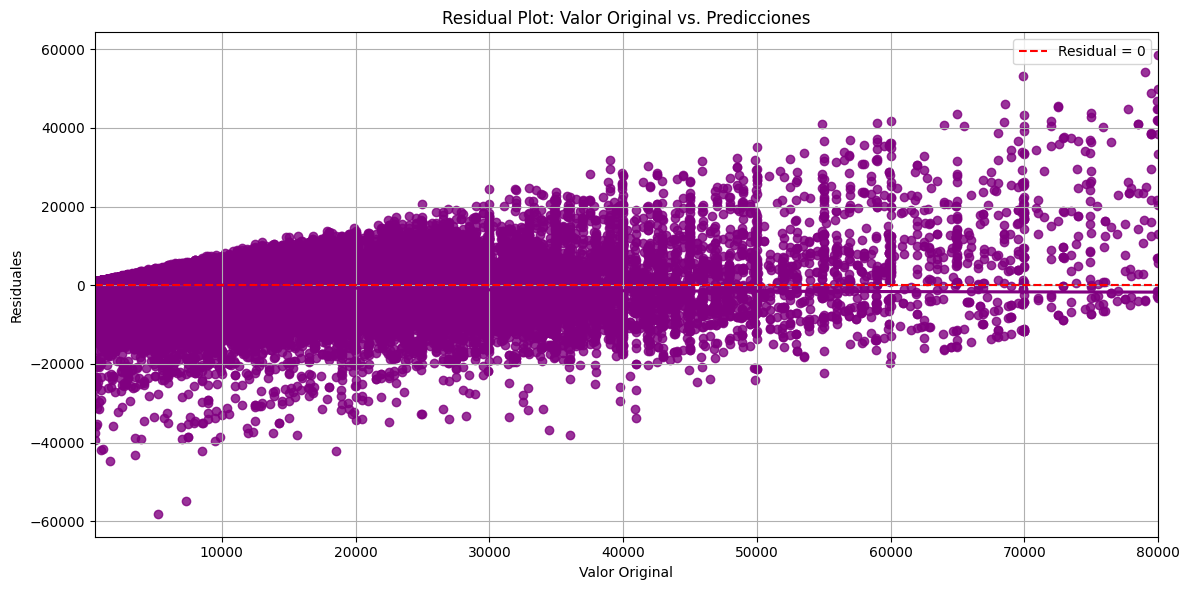

In [108]:
residual_plot(df_comparador,"price","price_pred")